# Accelerated Time Failure Model

In [26]:
import numpy as np
import pandas as pd
from lifelines import WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter, KaplanMeierFitter
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
import os

In [4]:
# Obtener la ruta absoluta del directorio actual (donde está el script o notebook)
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Subimos un nivel

# Construir la ruta relativa a la carpeta "Datos"
ruta_bdd = os.path.join(base_dir, "Datos", "database.xlsx")


In [7]:
data = pd.read_excel(ruta_bdd, sheet_name=None)

In [9]:
# Concatenamos los dataframes de cada key:
data = pd.concat(data.values(), ignore_index=True)
data

,FECHA,Caudal,TPH,% Solido,Presion,Bateria,Ciclón,Medicion,horometro,camino_id,uso_230,dias_230,score,score_out,censura
0,2019-03-18,3567.266049,4439.044013,69.998983,9.815361,BHC 1011,CyA,240.0,17987.828125,1011 CyA_2018-09-03,2365.541992,196,9.856425,0,1
1,2022-05-13,3756.696993,4076.248047,71.444245,9.866353,BHC 1011,CyA,236.0,33166.873535,1011 CyA_2020-06-15,8834.516113,697,37.434390,0,0
2,2024-08-18,5618.364990,4718.561523,59.569263,10.484711,BHC 1011,CyB,233.5,50149.431641,1011 CyB_2024-07-31,148.064453,18,0.634109,0,0
3,2022-05-13,3738.033100,4269.164081,71.362879,9.806812,BHC 1011,CyD,238.0,36061.521484,1011 CyD_2019-10-08,13360.652344,948,56.137195,0,0
4,2022-05-13,3738.033100,4269.164081,71.362879,9.806812,BHC 1011,CyE,236.5,20767.724365,1011 CyE_2019-10-08,6093.750732,948,25.766388,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,2019-03-18,5058.290852,4678.277867,72.800847,9.746337,BHC 1014,CyC,240.0,32302.919922,1014 CyC_2017-11-07,6827.429688,496,28.447624,0,1
58,2024-10-26,4945.517108,4583.328667,71.168770,10.041899,BHC 1014,CyC,237.0,64659.705078,1014 CyC_2023-01-10,9806.185547,655,41.376310,0,0
59,2019-10-08,5024.552795,4677.091022,72.171024,9.753665,BHC 1014,CyI,235.0,31384.193848,1014 CyI_2017-11-07,8050.506348,700,34.257474,0,0
60,2024-10-26,4945.517108,4583.328667,71.168770,10.041899,BHC 1014,CyI,239.0,56117.800781,1014 CyI_2023-01-10,9014.462891,655,37.717418,0,0


## Implementación AFT

Primero verificaremos que la distribución distinta de censuras sea (o no) aleatoria:

In [12]:
data["censura"].value_counts()

censura
0    36
1    26
Name: count, dtype: int64

In [13]:
from scipy.stats import ks_2samp

ks_stat, p_value = ks_2samp(data[data["censura"] == 1]["dias_230"], data[data["censura"] == 0]["censura"])
print(f"Estadístico KS: {ks_stat:.4f}, p-valor: {p_value:.4f}")

if p_value < 0.05:
    print("Las distribuciones de censurados y no censurados son significativamente diferentes.")
else:
    print("No hay evidencia suficiente para afirmar que las distribuciones sean diferentes.")


Estadístico KS: 1.0000, p-valor: 0.0000
Las distribuciones de censurados y no censurados son significativamente diferentes.


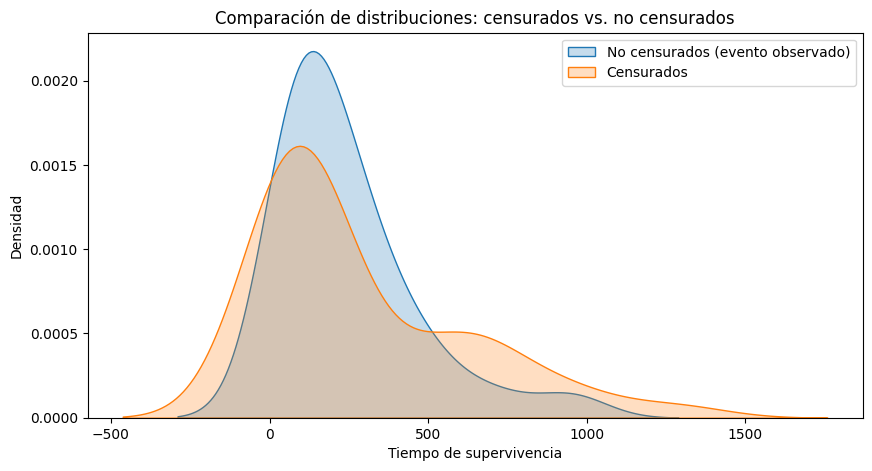

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.kdeplot(data[data["censura"] == 1]["dias_230"], label="No censurados (evento observado)", fill=True)
sns.kdeplot(data[data["censura"] == 0]["dias_230"], label="Censurados", fill=True)
plt.xlabel("Tiempo de supervivencia")
plt.ylabel("Densidad")
plt.title("Comparación de distribuciones: censurados vs. no censurados")
plt.legend()
plt.show()


Hay presencia de desbalanceo en los datos. Corregiremos esto mediante IPW:


--- Modelo Weibull ---
Weibull ponderado - AIC: 683.45


c:\Users\nacho\AppData\Local\Programs\Python\Python310\lib\site-packages\lifelines\fitters\__init__.py:1379: StatisticalWarning: It appears your weights are not integers, possibly propensity or sampling scores then?
                                        It's important to know that the naive variance estimates of the coefficients are biased. Instead a) set `robust=True` in the call to `fit`, or b) use Monte Carlo to
                                        estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis
  warnings.warn(


Weibull no ponderado - AIC: 394.90

Resumen del modelo ponderado:
                       coef  exp(coef)  se(coef)  coef lower 95%  \
param   covariate                                                  
lambda_ Intercept -3.180624   0.041560  6.059815      -15.057645   
        Caudal    -0.000944   0.999056  0.000291       -0.001514   
        TPH        0.001194   1.001195  0.000700       -0.000178   
        % Solido   0.032477   1.033010  0.016847       -0.000543   
        Presion    0.643615   1.903349  0.534048       -0.403101   
rho_    Intercept  0.207410   1.230487  0.116102       -0.020145   

                   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
param   covariate                                                             
lambda_ Intercept        8.696396         2.887673e-07          5981.314579   
        Caudal          -0.000374         9.984871e-01             0.999626   
        TPH              0.002567         9.998216e-01             1.0025

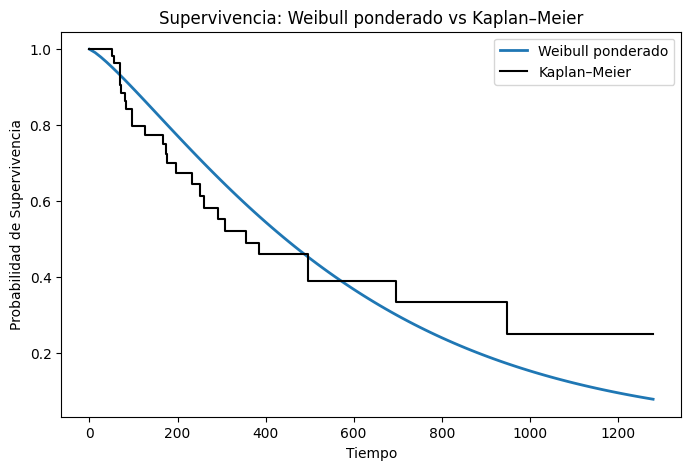


--- Modelo LogNormal ---


c:\Users\nacho\AppData\Local\Programs\Python\Python310\lib\site-packages\lifelines\fitters\__init__.py:1379: StatisticalWarning: It appears your weights are not integers, possibly propensity or sampling scores then?
                                        It's important to know that the naive variance estimates of the coefficients are biased. Instead a) set `robust=True` in the call to `fit`, or b) use Monte Carlo to
                                        estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis
  warnings.warn(


LogNormal ponderado - AIC: 678.53
LogNormal no ponderado - AIC: 390.78

Resumen del modelo ponderado:
                      coef   exp(coef)  se(coef)  coef lower 95%  \
param  covariate                                                   
mu_    Intercept  5.136361  170.095743  6.879273       -8.346767   
       Caudal    -0.000486    0.999514  0.000261       -0.000998   
       TPH       -0.000043    0.999957  0.000675       -0.001367   
       % Solido   0.018393    1.018564  0.016023       -0.013012   
       Presion    0.202423    1.224366  0.641869       -1.055618   
sigma_ Intercept  0.096617    1.101438  0.106419       -0.111960   

                  coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
param  covariate                                                             
mu_    Intercept       18.619489             0.000237         1.219949e+08   
       Caudal           0.000026             0.999002         1.000026e+00   
       TPH              0.001280         

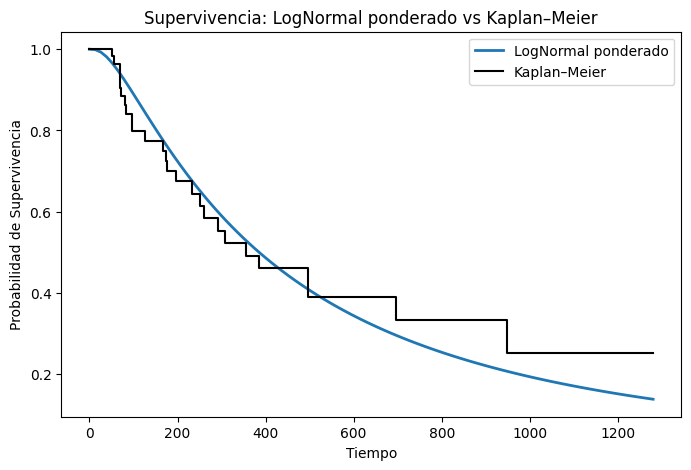


--- Modelo LogLogistic ---
LogLogistic ponderado - AIC: 681.41


c:\Users\nacho\AppData\Local\Programs\Python\Python310\lib\site-packages\lifelines\fitters\__init__.py:1379: StatisticalWarning: It appears your weights are not integers, possibly propensity or sampling scores then?
                                        It's important to know that the naive variance estimates of the coefficients are biased. Instead a) set `robust=True` in the call to `fit`, or b) use Monte Carlo to
                                        estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis
  warnings.warn(


LogLogistic no ponderado - AIC: 392.78

Resumen del modelo ponderado:
                      coef   exp(coef)  se(coef)  coef lower 95%  \
param  covariate                                                   
alpha_ Intercept  5.907541  367.800525  8.584493      -10.917757   
       Caudal    -0.000619    0.999381  0.000291       -0.001189   
       TPH        0.000264    1.000264  0.000717       -0.001141   
       % Solido   0.023684    1.023967  0.015708       -0.007103   
       Presion    0.009774    1.009822  0.825573       -1.608319   
beta_  Intercept  0.428480    1.534923  0.116503        0.200138   

                  coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
param  covariate                                                             
alpha_ Intercept       22.732839             0.000018         7.460129e+09   
       Caudal          -0.000049             0.998811         9.999514e-01   
       TPH              0.001669             0.998859         1.001670e+0

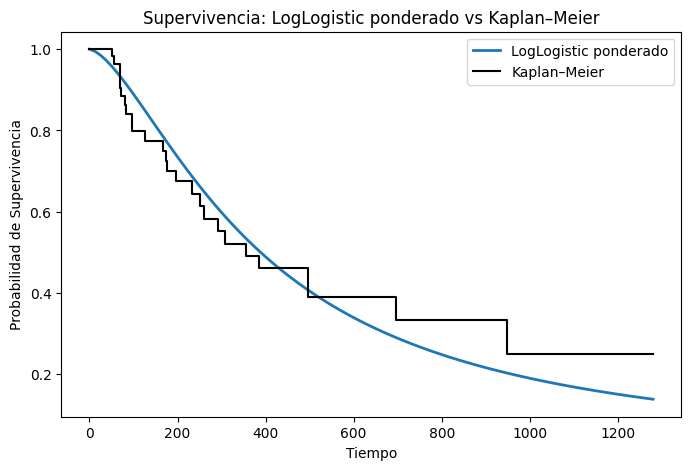


Comparación de AIC entre modelos:
        Modelo  AIC (ponderado)  AIC (no ponderado)
0      Weibull       683.445226          394.902606
1    LogNormal       678.527686          390.776021
2  LogLogistic       681.411453          392.779664

El mejor modelo según AIC (ponderado) es: LogNormal


In [27]:
# Importar librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# -----------------------------
# 1. Calcular pesos IPW
# -----------------------------

covariables = ["Caudal", "TPH", "% Solido", "Presion"]

# Se predice la probabilidad de NO estar censurado (1 - censura)
logit = LogisticRegression()
logit.fit(data[covariables], 1 - data["censura"])
data["p_censura"] = logit.predict_proba(data[covariables])[:, 1]

# Calcular los pesos IPW: a menor probabilidad de no censurado, mayor peso
data["IPW"] = 1 / data["p_censura"]

# -----------------------------
# 2. Ajustar modelos AFT con y sin IPW
# -----------------------------
# Definir los modelos a evaluar
model_dict = {
    "Weibull": WeibullAFTFitter(),
    "LogNormal": LogNormalAFTFitter(),
    "LogLogistic": LogLogisticAFTFitter()
}

# Diccionario para almacenar los resultados
results = {}

for model_name, model in model_dict.items():
    print(f"\n--- Modelo {model_name} ---")
    
    # Ajuste ponderado (con IPW)
    modelo_ponderado = model.__class__()  # Crear nueva instancia del mismo tipo de modelo
    modelo_ponderado.fit(data,
                         duration_col="dias_230",
                         event_col="censura",
                         weights_col="IPW",
                         # Si el nombre de la columna "% Solido" tiene espacios o símbolos especiales, en la fórmula se encierran entre backticks.
                         formula="Caudal + TPH + `% Solido` + Presion")
    print(f"{model_name} ponderado - AIC: {modelo_ponderado.AIC_:.2f}")
    
    # Ajuste no ponderado (sin IPW)
    modelo_no_ponderado = model.__class__()
    modelo_no_ponderado.fit(data,
                            duration_col="dias_230",
                            event_col="censura",
                            formula="Caudal + TPH + `% Solido` + Presion")
    print(f"{model_name} no ponderado - AIC: {modelo_no_ponderado.AIC_:.2f}")
    
    # Almacenar resultados
    results[model_name] = {
        "ponderado": modelo_ponderado,
        "no_ponderado": modelo_no_ponderado
    }
    
    # Mostrar resumen de cada ajuste
    print("\nResumen del modelo ponderado:")
    print(modelo_ponderado.summary)
    print("\nResumen del modelo no ponderado:")
    print(modelo_no_ponderado.summary)
    
    # -----------------------------
    # 3. Chequeo de supuestos: Comparación de la función de supervivencia ajustada con Kaplan–Meier
    # -----------------------------
    # Se define un perfil “típico” usando la media de cada covariable
    perfil = pd.DataFrame({var: [data[var].mean()] for var in covariables})
    
    # Calcular la función de supervivencia estimada por el modelo ponderado
    tiempos = np.linspace(0, data["dias_230"].max(), 100)
    sf_modelo = modelo_ponderado.predict_survival_function(perfil, times=tiempos)
    
    # Ajustar el estimador Kaplan–Meier con todos los datos (no estratificado)
    kmf = KaplanMeierFitter()
    kmf.fit(data["dias_230"], event_observed=data["censura"])
    
    # Graficar la función de supervivencia del modelo versus Kaplan–Meier
    plt.figure(figsize=(8, 5))
    plt.plot(tiempos, sf_modelo.iloc[:, 0], label=f"{model_name} ponderado", lw=2)
    plt.step(kmf.survival_function_.index,
             kmf.survival_function_["KM_estimate"],
             where="post", label="Kaplan–Meier", color="black")
    plt.xlabel("Tiempo")
    plt.ylabel("Probabilidad de Supervivencia")
    plt.title(f"Supervivencia: {model_name} ponderado vs Kaplan–Meier")
    plt.legend()
    plt.show()
    
    # Se podría realizar un análisis similar para el ajuste no ponderado si se desea.

# -----------------------------
# 4. Comparar los modelos mediante AIC y escoger el mejor
# -----------------------------
comparacion_aic = []
for nombre, ajustes in results.items():
    comparacion_aic.append({
        "Modelo": nombre,
        "AIC (ponderado)": ajustes["ponderado"].AIC_,
        "AIC (no ponderado)": ajustes["no_ponderado"].AIC_
    })

df_aic = pd.DataFrame(comparacion_aic)
print("\nComparación de AIC entre modelos:")
print(df_aic)

# Ejemplo de criterio: escoger el modelo con menor AIC en el ajuste ponderado
mejor_modelo = df_aic.loc[df_aic["AIC (ponderado)"].idxmin(), "Modelo"]
print(f"\nEl mejor modelo según AIC (ponderado) es: {mejor_modelo}")

# -----------------------------
# Comentarios adicionales:
# - Se pueden profundizar los análisis de supuestos realizando, por ejemplo,
#   análisis de residuos o validación cruzada.
# - También es posible comparar las curvas de supervivencia predichas para distintos perfiles de riesgo.
# - Asegúrate de que los nombres de las columnas en la fórmula coincidan exactamente con los de tu DataFrame.
# - Este código te permite comparar el impacto del balanceo (usando IPW) frente a los datos sin balancear.


## Evaluación del modelo:

c:\Users\nacho\AppData\Local\Programs\Python\Python310\lib\site-packages\lifelines\fitters\__init__.py:1379: StatisticalWarning: It appears your weights are not integers, possibly propensity or sampling scores then?
                                        It's important to know that the naive variance estimates of the coefficients are biased. Instead a) set `robust=True` in the call to `fit`, or b) use Monte Carlo to
                                        estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis
  warnings.warn(


Resumen del modelo LogNormal (entrenamiento):


coef    exp(coef)  se(coef)  coef lower 95%  \
param  covariate                                                    
mu_    Intercept  7.254029  1413.788948  8.103630       -8.628793   
       Caudal    -0.001297     0.998703  0.000256       -0.001799   
       TPH        0.000843     1.000843  0.000558       -0.000250   
       % Solido   0.017542     1.017696  0.015368       -0.012580   
       Presion   -0.024608     0.975692  0.833773       -1.658773   
sigma_ Intercept -0.173104     0.841050  0.110340       -0.389366   

                  coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  \
param  covariate                                                             
mu_    Intercept       23.136851             0.000179         1.117395e+10   
       Caudal          -0.000796             0.998203         9.992044e-01   
       TPH              0.001936             0.999750         1.001938e+00   
       % Solido         0.047663             0.987499         1.048817e+00   
       Presion          1.609557             0.190372         5.000594e+00   
sigma_ Intercept        0.043158             0.677486         1.044103e+00   

                  cmp to         z             p   -log2(p)  
param  covariate                                             
mu_    Intercept     0.0  0.895158  3.707026e-01   1.431666  
       Caudal        0.0 -5.070849  3.960451e-07  21.267832  
       TPH           0.0  1.511163  1.307470e-01   2.935150  
       % Solido      0.0  1.141422  2.536944e-01   1.978836  
       Presion       0.0 -0.029514  9.764546e-01   0.034375  
sigma_ Intercept     0.0 -1.568830  1.166877e-01   3.099276


Índice de concordancia (c-index) en test: 0.582


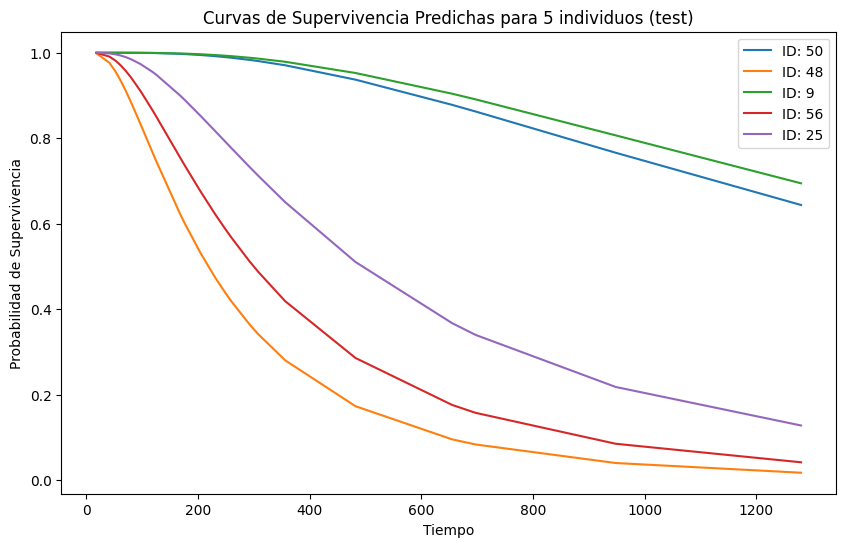


Horizonte de calibración T = 174.0

Resumen de calibración por grupo:


C:\Users\nacho\AppData\Local\Temp\ipykernel_11708\466739058.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_summary = test_data.groupby("grupo").apply(lambda df: pd.Series({
C:\Users\nacho\AppData\Local\Temp\ipykernel_11708\466739058.py:85: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group_summary = test_data.groupby("grupo").apply(lambda df: pd.Series({


,grupo,pred_surv_media,KM_surv
0,"(0.304, 0.628]",0.455598,0.0
1,"(0.628, 0.72]",0.669813,0.5
2,"(0.72, 0.734]",0.729185,1.0
3,"(0.734, 0.75]",0.741234,1.0
4,"(0.75, 0.827]",0.804236,1.0
5,"(0.827, 0.885]",0.856159,1.0
6,"(0.885, 0.978]",0.928667,0.5
7,"(0.978, 0.991]",0.986783,1.0
8,"(0.991, 0.997]",0.996209,1.0
9,"(0.997, 0.998]",0.997800,0.0


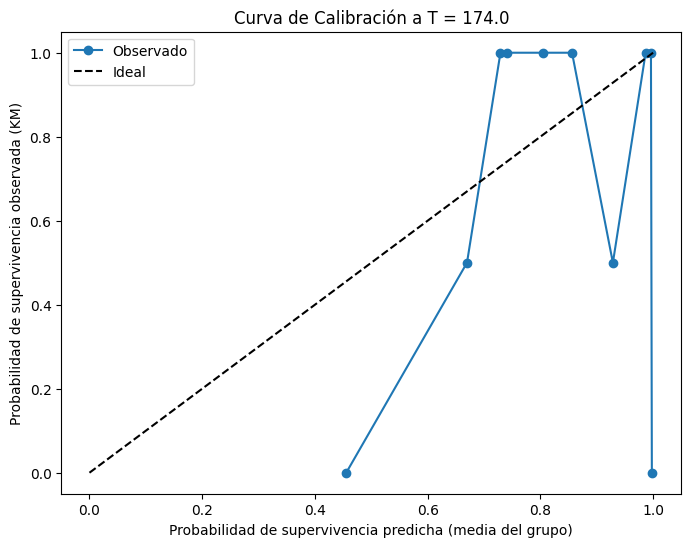


Tabla de predicciones (primeras 10 filas):


,dias_230,censura,pred_surv_T,predicted_median
50,45,0,0.996943,1745.716106
56,655,0,0.741008,299.692428
0,196,1,0.995474,1562.858247
57,496,1,0.729185,290.728244
5,56,0,0.997580,1860.615142
48,97,1,0.606447,218.371627
16,82,1,0.706590,274.821966
12,385,1,0.987290,1139.972149
25,110,0,0.892096,492.781570
59,700,0,0.741459,300.044397


In [28]:
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index
from IPython.display import display

# -----------------------------
# 1. División de los datos en entrenamiento y prueba
# -----------------------------
# Se asume que 'data' es tu DataFrame original con las siguientes columnas:
# "dias_230": tiempo, "censura": evento (1 si ocurrió, 0 si no)
# y las covariables: "Caudal", "TPH", "% Solido", "Presion"

train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# -----------------------------
# 2. Recalcular pesos IPW en el conjunto de entrenamiento
# -----------------------------
covariables = ["Caudal", "TPH", "% Solido", "Presion"]

logit = LogisticRegression()
# Se estima la probabilidad de NO estar censurado
logit.fit(train_data[covariables], 1 - train_data["censura"])
train_data["p_censura"] = logit.predict_proba(train_data[covariables])[:, 1]
train_data["IPW"] = 1 / train_data["p_censura"]

# -----------------------------
# 3. Ajustar el modelo LogNormalAFTFitter (el mejor según AIC, ponderado) en entrenamiento
# -----------------------------
lognormal_model = LogNormalAFTFitter()

# Nota: si el nombre de la columna "% Solido" tiene símbolos o espacios, se utiliza con backticks en la fórmula.
formula_str = "Caudal + TPH + `% Solido` + Presion"

lognormal_model.fit(train_data,
                      duration_col="dias_230",
                      event_col="censura",
                      weights_col="IPW",
                      formula=formula_str)
print("Resumen del modelo LogNormal (entrenamiento):")
display(lognormal_model.summary)

# -----------------------------
# 4. Evaluación en el conjunto de prueba
# -----------------------------

# 4.1. Predicción de la mediana de supervivencia en el conjunto de prueba
predicted_medians = lognormal_model.predict_median(test_data)

# Calcular el índice de concordancia (c-index)
# Se usa -predicted_medians ya que en modelos de riesgo mayor (menor mediana) se asocia a mayor riesgo.
ci = concordance_index(test_data["dias_230"], -predicted_medians, test_data["censura"])
print(f"\nÍndice de concordancia (c-index) en test: {ci:.3f}")

# 4.2. Graficar curvas de supervivencia predichas para algunos individuos del conjunto de prueba
sample_indices = test_data.sample(5, random_state=42).index  # Seleccionar 5 individuos al azar
plt.figure(figsize=(10,6))
for idx in sample_indices:
    sf = lognormal_model.predict_survival_function(test_data.loc[[idx]])
    plt.plot(sf.index, sf.iloc[:, 0], label=f"ID: {idx}")
plt.xlabel("Tiempo")
plt.ylabel("Probabilidad de Supervivencia")
plt.title("Curvas de Supervivencia Predichas para 5 individuos (test)")
plt.legend()
plt.show()

# 4.3. Curva de calibración a un horizonte de tiempo T
# Seleccionamos T (por ejemplo, la mediana del tiempo en el entrenamiento)
T = np.median(train_data["dias_230"])
print(f"\nHorizonte de calibración T = {T:.1f}")

# Para cada individuo del conjunto de prueba, obtener la probabilidad de supervivencia a T
pred_surv_probs = []
for i in test_data.index:
    # La función predict_survival_function devuelve un DataFrame con el tiempo como índice.
    sf = lognormal_model.predict_survival_function(test_data.loc[[i]], times=[T])
    pred_surv_probs.append(sf.iloc[0, 0])
test_data = test_data.copy()  # Para evitar SettingWithCopyWarning
test_data["pred_surv_T"] = pred_surv_probs

# Dividir en grupos (por ejemplo, en deciles) según la probabilidad predicha a T
test_data["grupo"] = pd.qcut(test_data["pred_surv_T"], q=10)

# Para cada grupo, calcular:
# - La probabilidad de supervivencia predicha media a T.
# - La supervivencia observada a T (estimada vía Kaplan–Meier)
group_summary = test_data.groupby("grupo").apply(lambda df: pd.Series({
    "pred_surv_media": df["pred_surv_T"].mean(),
    "KM_surv": KaplanMeierFitter().fit(df["dias_230"], event_observed=df["censura"]).predict(T)
})).reset_index()

print("\nResumen de calibración por grupo:")
display(group_summary)

# Graficar la curva de calibración
plt.figure(figsize=(8,6))
plt.plot(group_summary["pred_surv_media"], group_summary["KM_surv"], "o-", label="Observado")
plt.plot([0,1], [0,1], "k--", label="Ideal")
plt.xlabel("Probabilidad de supervivencia predicha (media del grupo)")
plt.ylabel("Probabilidad de supervivencia observada (KM)")
plt.title(f"Curva de Calibración a T = {T:.1f}")
plt.legend()
plt.show()

# -----------------------------
# 5. Tabla resumen de predicciones para interpretación-
# -----------------------------
# Se muestra una tabla con:
# - Tiempo observado, censura, probabilidad de supervivencia predicha a T y mediana predicha.
results_table = test_data[["dias_230", "censura", "pred_surv_T"]].copy()
results_table["predicted_median"] = lognormal_model.predict_median(test_data)
print("\nTabla de predicciones (primeras 10 filas):")
display(results_table.head(10))
